In [6]:

!pip install -q torchvision matplotlib


In [2]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
from PIL import Image
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from collections import Counter
from torchvision.transforms import ToTensor, Resize, Grayscale, RandomRotation, RandomAffine
from torchvision.transforms import functional as F_transforms

In [3]:


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
# === uploaded: kkanji.tar and KMNIST npz loaded via torchvision ===
kanji_tar = "kkanji.tar"
kanji_folder = "kkanji"

if not os.path.exists(kanji_folder):
    os.makedirs(kanji_folder, exist_ok=True)
    with tarfile.open(kanji_tar, 'r') as tar:
        tar.extractall(path=kanji_folder)

from torchvision.datasets import KMNIST
kmnist_train = KMNIST(root='./', train=True, download=True)

# === Transforms ===
from torchvision.transforms import ToTensor, Resize, Grayscale, RandomRotation, RandomAffine

train_transform = transforms.Compose([
    RandomRotation(10),
    RandomAffine(0, translate=(0.1, 0.1)),
    Resize((64, 64)),
    Grayscale(num_output_channels=3),
    ToTensor()
])

val_transform = transforms.Compose([
    Resize((64, 64)),
    Grayscale(num_output_channels=3),
    ToTensor()
])

test_transform = val_transform

# === Static Dataset: Fixed Characters for All Epochs ===
class KanjiKanaDataset(Dataset):
    def __init__(self, max_per_class=2000):
        self.images = []

        # Load KMNIST kana
        kana_images = []
        for i in range(len(kmnist_train)):
            if len(kana_images) >= max_per_class:
                break
            img = Image.fromarray(kmnist_train.data[i].numpy())
            kana_images.append((img, 0))

        # Load Kanji from nested kkanji2/U+xxxx/*.png structure
        kanji_images = []
        kkanji2_root = os.path.join(kanji_folder, "kkanji2")
        for ucode_dir in os.listdir(kkanji2_root):
            subdir = os.path.join(kkanji2_root, ucode_dir)
            if os.path.isdir(subdir):
                for img_file in os.listdir(subdir):
                    if img_file.lower().endswith('.png'):
                        img_path = os.path.join(subdir, img_file)
                        try:
                            img = Image.open(img_path).convert("L")
                            kanji_images.append((img, 1))
                            if len(kanji_images) >= max_per_class:
                                break
                        except Exception as e:
                            print(f"Skipping {img_path}: {e}")
            if len(kanji_images) >= max_per_class:
                break

        if len(kanji_images) == 0:
            raise RuntimeError("No kanji images were found under kkanji/kkanji2/U+xxxx/")

        self.images = kana_images + kanji_images
        random.shuffle(self.images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx]
        return img, int(label)

# === Dynamic Resampling Dataset: Resamples a fresh set each epoch ===
class DynamicKanjiKanaDataset(Dataset):
    def __init__(self, kana_pool, kanji_root, max_per_class=2000, transform=None):
        self.kana_pool = kana_pool
        self.kanji_root = kanji_root
        self.max_per_class = max_per_class
        self.transform = transform
        self.refresh()

    def refresh(self):
        self.images = []
        kana_indices = torch.randperm(len(self.kana_pool))[:self.max_per_class]
        for i in kana_indices:
            img = Image.fromarray(self.kana_pool[i].numpy())
            self.images.append((img, 0))

        kanji_images = []
        for ucode_dir in os.listdir(self.kanji_root):
            subdir = os.path.join(self.kanji_root, ucode_dir)
            if os.path.isdir(subdir):
                for img_file in os.listdir(subdir):
                    if img_file.lower().endswith('.png'):
                        img_path = os.path.join(subdir, img_file)
                        try:
                            img = Image.open(img_path).convert("L")
                            kanji_images.append(img)
                        except: pass
        random.shuffle(kanji_images)
        for img in kanji_images[:self.max_per_class]:
            self.images.append((img, 1))

        random.shuffle(self.images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img, int(label)


# Create full dataset and 3-way split
full_ds = KanjiKanaDataset()
total_size = len(full_ds)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_raw, val_raw, test_raw = torch.utils.data.random_split(
    full_ds, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)



class TransformWrapper(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return self.transform(img), int(label)

train_ds = TransformWrapper(train_raw, train_transform)
val_ds = TransformWrapper(val_raw, val_transform)
test_ds = TransformWrapper(test_raw, test_transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)


# === Sanity check: label distribution ===
def check_label_distribution(dl, name):
    counts = Counter()
    for _, labels in dl:
        counts.update(labels.tolist())
    print(f"{name} label distribution:", counts)

check_label_distribution(train_dl, "Train")
check_label_distribution(val_dl, "Val")
check_label_distribution(test_dl, "Test")




Train label distribution: Counter({0: 1411, 1: 1389})
Val label distribution: Counter({0: 307, 1: 293})
Test label distribution: Counter({1: 318, 0: 282})


In [9]:


# === Evaluate and Plot ===
def evaluate_model(model, val_dl):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(device)
            preds = model(xb)
            pred_labels = torch.argmax(preds, dim=1).cpu().numpy()
            y_pred.extend(pred_labels)
            y_true.extend(yb.numpy())
    print(classification_report(y_true, y_pred, target_names=["kana", "kanji"]))

# === Plot training and validation curves ===
def plot_training(history, model_name):
    epochs = len(history['train_loss'])
    x = range(1, epochs + 1)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, history['train_loss'], label='Train Loss')
    plt.plot(x, history['val_loss'], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, history['train_acc'], label='Train Acc')
    plt.plot(x, history['val_acc'], label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Training: Save Best Model ===
def train_model(model, train_dl, val_dl, model_name="Model", epochs=50, patience=5):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for xb, yb in loop:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            total += yb.size(0)
            correct += (preds.argmax(1) == yb).sum().item()

            loop.set_postfix(loss=loss.item())

        scheduler.step()
        train_acc = correct / total
        train_loss /= total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss += criterion(preds, yb).item() * xb.size(0)
                val_total += yb.size(0)
                val_correct += (preds.argmax(1) == yb).sum().item()

        val_acc = val_correct / val_total
        val_loss /= val_total

        print(f"Epoch {epoch+1}/{epochs} — loss: {train_loss:.4f} — accuracy: {train_acc:.4f} — val_loss: {val_loss:.4f} — val_accuracy: {val_acc:.4f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve_epochs = 0
            torch.save(model.state_dict(), f"best_{model_name.lower()}.pth")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("Early stopping triggered.")
                break
    if model.state_dict() is not None:
      model.load_state_dict(best_model_state)
      torch.save(model.state_dict(), f"best_{model_name.lower()}.pth")

   # model.load_state_dict(best_model_state)
    plot_training(history, model_name)
    return model


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]



Training ResNet50...


Epoch 1/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1/50 — loss: 0.1627 — accuracy: 0.9664 — val_loss: 0.0001 — val_accuracy: 1.0000


Epoch 2/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2/50 — loss: 0.0142 — accuracy: 0.9957 — val_loss: 0.0015 — val_accuracy: 1.0000


Epoch 3/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3/50 — loss: 0.0013 — accuracy: 0.9996 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 4/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4/50 — loss: 0.0074 — accuracy: 0.9971 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 5/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5/50 — loss: 0.0056 — accuracy: 0.9971 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 6/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6/50 — loss: 0.0024 — accuracy: 0.9993 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 7/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 8/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 9/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9/50 — loss: 0.0001 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 10/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 11/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 11/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 12/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 12/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 13/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 14/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 15/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 15/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 16/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 16/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 17/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 17/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 18/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 18/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 19/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 19/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 20/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 20/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 21/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 21/50 — loss: 0.0001 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 22/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 22/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 23/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 23/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 24/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 24/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 25/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 25/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 26/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 26/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 27/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 27/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 28/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 28/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 29/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 29/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 30/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 30/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 31/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 31/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 32/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 32/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 33/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 33/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 34/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 34/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 35/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 35/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 36/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 36/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 37/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 37/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000
Early stopping triggered.


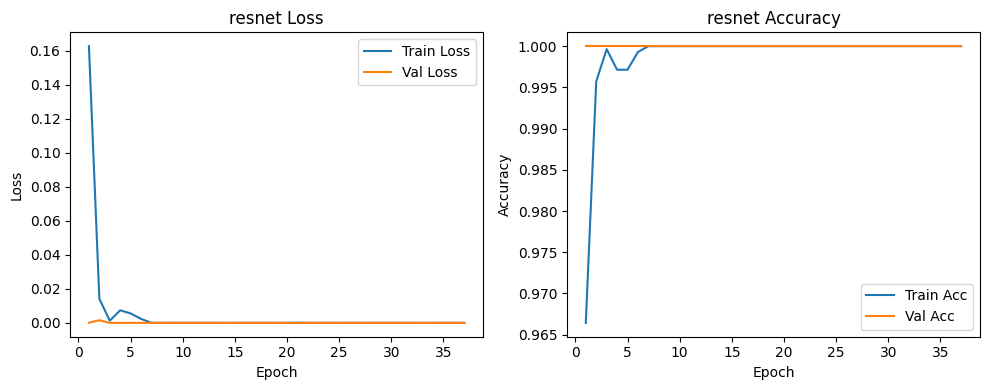

              precision    recall  f1-score   support

        kana       1.00      1.00      1.00       307
       kanji       1.00      1.00      1.00       293

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 188MB/s]



Training DenseNet121...


Epoch 1/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1/50 — loss: 0.0968 — accuracy: 0.9711 — val_loss: 0.0018 — val_accuracy: 1.0000


Epoch 2/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2/50 — loss: 0.0057 — accuracy: 0.9979 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 3/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3/50 — loss: 0.0092 — accuracy: 0.9964 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 4/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4/50 — loss: 0.0001 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 5/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 6/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6/50 — loss: 0.0000 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 7/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7/50 — loss: 0.0022 — accuracy: 0.9993 — val_loss: 0.0006 — val_accuracy: 1.0000


Epoch 8/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8/50 — loss: 0.0023 — accuracy: 0.9996 — val_loss: 0.0071 — val_accuracy: 0.9983


Epoch 9/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9/50 — loss: 0.0138 — accuracy: 0.9954 — val_loss: 0.0369 — val_accuracy: 0.9883


Epoch 10/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10/50 — loss: 0.0002 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000


Epoch 11/50:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 11/50 — loss: 0.0002 — accuracy: 1.0000 — val_loss: 0.0000 — val_accuracy: 1.0000
Early stopping triggered.


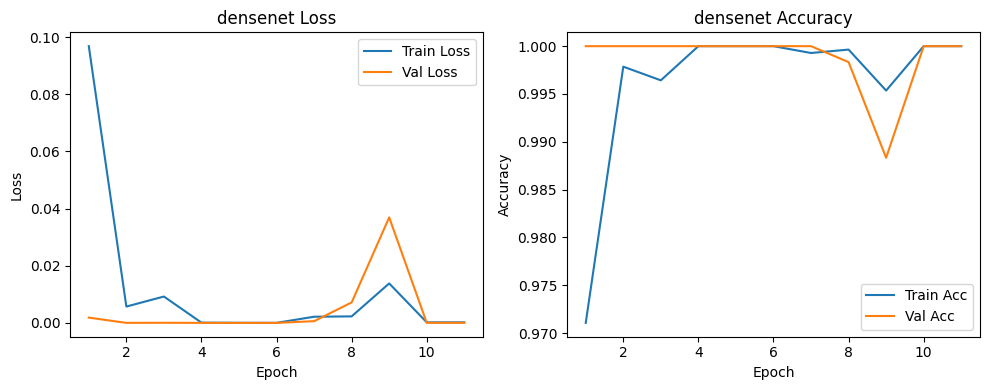

              precision    recall  f1-score   support

        kana       1.00      1.00      1.00       307
       kanji       1.00      1.00      1.00       293

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [10]:
# === Train with ResNet50 and DenseNet121 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet50
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
print("\nTraining ResNet50...")
resnet = train_model(resnet, train_dl, val_dl, model_name="resnet")
evaluate_model(resnet, val_dl)

# DenseNet121
densenet = models.densenet121(pretrained=True)
densenet.classifier = nn.Linear(densenet.classifier.in_features, 2)
print("\nTraining DenseNet121...")
densenet = train_model(densenet, train_dl, val_dl, model_name ="densenet")
evaluate_model(densenet, val_dl)


In [11]:

print("\n Final Evaluation on Test Set:")

print("\n[ResNet50 Test]")
evaluate_model(resnet, test_dl)

print("\n[DenseNet121 Test]")
evaluate_model(densenet, test_dl)


 Final Evaluation on Test Set:

[ResNet50 Test]
              precision    recall  f1-score   support

        kana       1.00      1.00      1.00       282
       kanji       1.00      1.00      1.00       318

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


[DenseNet121 Test]
              precision    recall  f1-score   support

        kana       1.00      1.00      1.00       282
       kanji       1.00      1.00      1.00       318

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [12]:
# === Dynamic Resampling Training Loop ===
def train_model_dynamic(model, kana_pool, kanji_root, epochs=10, batch_size=32, patience=7, model_name = "Model"):
    from collections import Counter
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Start with a higher LR
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=4, verbose=True)
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0

    for epoch in range(epochs):
        print(f"\n Epoch {epoch+1}/{epochs} — refreshing dynamic dataset...")

        dynamic_ds = DynamicKanjiKanaDataset(kana_pool=kana_pool, kanji_root=kanji_root, transform=None)
        dynamic_ds.refresh()

        # === Show label distribution after refresh ===
        label_counter = Counter([label for _, label in dynamic_ds.images])
        print(f"Label distribution after refresh: {label_counter}")

        total_size = len(dynamic_ds)
        train_size = int(0.7 * total_size)
        val_size = int(0.15 * total_size)
        test_size = total_size - train_size - val_size

        train_raw, val_raw, test_raw = torch.utils.data.random_split(
            dynamic_ds, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42 + epoch)
        )

        train_ds = TransformWrapper(train_raw, train_transform)
        val_ds = TransformWrapper(val_raw, val_transform)
        test_ds = TransformWrapper(test_raw, test_transform)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size)
        test_dl = DataLoader(test_ds, batch_size=batch_size)

        # Train for one epoch
        model.train()
        total_loss, total_correct = 0.0, 0
        for xb, yb in tqdm(train_dl, desc=f"[Training epoch {epoch+1}]"):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            total_correct += (preds.argmax(1) == yb).sum().item()

        acc = total_correct / len(train_dl.dataset)
        avg_loss = total_loss / len(train_dl.dataset)
        print(f"Train epoch {epoch+1} — loss: {avg_loss:.4f}, accuracy: {acc:.4f}")

        # Evaluate on val set
        model.eval()
        val_correct, val_total, val_loss_total, val_batches = 0, 0, 0.0, 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss_total += criterion(preds, yb).item()
                val_batches += 1
                val_total += yb.size(0)
                val_correct += (preds.argmax(1) == yb).sum().item()

        val_acc = val_correct / val_total
        val_loss = val_loss_total / val_batches if val_batches > 0 else 0
        print(f"Validation epoch {epoch+1} — val_loss: {val_loss:.4f}, val_accuracy: {val_acc:.4f}")
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve_epochs = 0
            torch.save(model.state_dict(), f"best_{model_name.lower()}.pth")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        torch.save(model.state_dict(), f"best_{model_name.lower()}.pth")
    print("Final evaluation on test set:")
    evaluate_model(model, test_dl)
    return model



In [ ]:

resnet_dynamic = models.resnet50(pretrained=True)
resnet_dynamic.fc = nn.Linear(resnet_dynamic.fc.in_features, 2)
trained_resnet_dynamic = train_model_dynamic(resnet_dynamic, kmnist_train.data, os.path.join(kanji_folder, "kkanji2"), epochs=50, model_name = "resnet_dynamic")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



 Epoch 1/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 1]:   0%|          | 0/88 [00:00<?, ?it/s]

In [ ]:
densenet_dynamic = models.densenet121(pretrained=True)
densenet_dynamic.classifier = nn.Linear(densenet_dynamic.classifier.in_features, 2)
trained_densenet_dynamic = train_model_dynamic(densenet_dynamic, kmnist_train.data, os.path.join(kanji_folder, "kkanji2"), epochs=50, model_name = "densenet_dynamic")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



 Epoch 1/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 1]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 1 — loss: 0.7949, accuracy: 0.9364
Validation epoch 1 — val_loss: 1.6849, val_accuracy: 0.7183

 Epoch 2/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 2]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 2 — loss: 0.0602, accuracy: 0.9843
Validation epoch 2 — val_loss: 889.5057, val_accuracy: 0.5433

 Epoch 3/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 3]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 3 — loss: 0.0689, accuracy: 0.9804
Validation epoch 3 — val_loss: 0.0891, val_accuracy: 0.9750

 Epoch 4/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 4]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 4 — loss: 0.0169, accuracy: 0.9957
Validation epoch 4 — val_loss: 0.0265, val_accuracy: 0.9967

 Epoch 5/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 5]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 5 — loss: 0.0045, accuracy: 0.9986
Validation epoch 5 — val_loss: 0.0561, val_accuracy: 0.9883

 Epoch 6/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 6]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 6 — loss: 0.0091, accuracy: 0.9964
Validation epoch 6 — val_loss: 0.3037, val_accuracy: 0.9050

 Epoch 7/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 7]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 7 — loss: 0.0143, accuracy: 0.9968
Validation epoch 7 — val_loss: 0.0107, val_accuracy: 0.9933

 Epoch 8/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 8]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 8 — loss: 0.0288, accuracy: 0.9918
Validation epoch 8 — val_loss: 0.0113, val_accuracy: 0.9950

 Epoch 9/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 9]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 9 — loss: 0.0106, accuracy: 0.9968
Validation epoch 9 — val_loss: 0.0073, val_accuracy: 0.9967

 Epoch 10/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 10]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 10 — loss: 0.0164, accuracy: 0.9954
Validation epoch 10 — val_loss: 0.0052, val_accuracy: 0.9967

 Epoch 11/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 11]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 11 — loss: 0.0099, accuracy: 0.9961
Validation epoch 11 — val_loss: 0.0008, val_accuracy: 1.0000

 Epoch 12/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 12]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 12 — loss: 0.0019, accuracy: 0.9989
Validation epoch 12 — val_loss: 0.0046, val_accuracy: 0.9983

 Epoch 13/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 13]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 13 — loss: 0.0045, accuracy: 0.9996
Validation epoch 13 — val_loss: 0.0394, val_accuracy: 0.9867

 Epoch 14/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 14]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 14 — loss: 0.0199, accuracy: 0.9946
Validation epoch 14 — val_loss: 0.0223, val_accuracy: 0.9950

 Epoch 15/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 15]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 15 — loss: 0.0069, accuracy: 0.9986
Validation epoch 15 — val_loss: 0.0079, val_accuracy: 0.9967

 Epoch 16/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 16]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 16 — loss: 0.0044, accuracy: 0.9993
Validation epoch 16 — val_loss: 0.0041, val_accuracy: 0.9983

 Epoch 17/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 17]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 17 — loss: 0.0012, accuracy: 0.9993
Validation epoch 17 — val_loss: 0.0001, val_accuracy: 1.0000

 Epoch 18/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 18]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 18 — loss: 0.0021, accuracy: 0.9996
Validation epoch 18 — val_loss: 0.0002, val_accuracy: 1.0000

 Epoch 19/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 19]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 19 — loss: 0.0027, accuracy: 0.9986
Validation epoch 19 — val_loss: 0.0000, val_accuracy: 1.0000

 Epoch 20/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 20]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 20 — loss: 0.0070, accuracy: 0.9982
Validation epoch 20 — val_loss: 0.0282, val_accuracy: 0.9950

 Epoch 21/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 21]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 21 — loss: 0.0068, accuracy: 0.9975
Validation epoch 21 — val_loss: 0.0001, val_accuracy: 1.0000

 Epoch 22/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 22]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 22 — loss: 0.0048, accuracy: 0.9986
Validation epoch 22 — val_loss: 0.0065, val_accuracy: 0.9983

 Epoch 23/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 23]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 23 — loss: 0.0043, accuracy: 0.9986
Validation epoch 23 — val_loss: 0.0004, val_accuracy: 1.0000

 Epoch 24/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 24]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 24 — loss: 0.0003, accuracy: 1.0000
Validation epoch 24 — val_loss: 0.0000, val_accuracy: 1.0000

 Epoch 25/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 25]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 25 — loss: 0.0008, accuracy: 0.9996
Validation epoch 25 — val_loss: 0.0082, val_accuracy: 0.9950

 Epoch 26/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 26]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 26 — loss: 0.0015, accuracy: 0.9996
Validation epoch 26 — val_loss: 0.0032, val_accuracy: 0.9983

 Epoch 27/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 27]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 27 — loss: 0.0189, accuracy: 0.9957
Validation epoch 27 — val_loss: 0.0004, val_accuracy: 1.0000

 Epoch 28/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 28]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 28 — loss: 0.0112, accuracy: 0.9964
Validation epoch 28 — val_loss: 0.0030, val_accuracy: 0.9983

 Epoch 29/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 29]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 29 — loss: 0.0047, accuracy: 0.9986
Validation epoch 29 — val_loss: 0.0806, val_accuracy: 0.9900

 Epoch 30/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({1: 2000, 0: 2000})


[Training epoch 30]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 30 — loss: 0.0049, accuracy: 0.9989
Validation epoch 30 — val_loss: 0.0002, val_accuracy: 1.0000

 Epoch 31/50 — refreshing dynamic dataset...
Label distribution after refresh: Counter({0: 2000, 1: 2000})


[Training epoch 31]:   0%|          | 0/88 [00:00<?, ?it/s]

Train epoch 31 — loss: 0.0069, accuracy: 0.9975
Validation epoch 31 — val_loss: 0.0000, val_accuracy: 1.0000
Early stopping triggered.
Final evaluation on test set:
              precision    recall  f1-score   support

        kana       0.99      1.00      1.00       296
       kanji       1.00      0.99      1.00       304

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [ ]:
def evaluate_ensemble(model1, model2, test_dl):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model1.eval()
    model2.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            out1 = torch.softmax(model1(xb), dim=1)
            out2 = torch.softmax(model2(xb), dim=1)
            avg_out = (out1 + out2) / 2
            final_preds = torch.argmax(avg_out, dim=1).cpu().numpy()
            y_pred.extend(final_preds)
            y_true.extend(yb.numpy())
    print("Ensemble Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["kana", "kanji"]))

In [ ]:
evaluate_ensemble(resnet,densenet,test_dl)

Ensemble Classification Report:
              precision    recall  f1-score   support

        kana       1.00      1.00      1.00       282
       kanji       1.00      1.00      1.00       318

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [ ]:
#evaluate_ensemble(resnet_dynamic,densenet_dynamic,test_dl)

In [ ]:


class InvertWrapper:
    def __call__(self, img):
        return F_transforms.invert(img)

# === Data Transforms ===
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    InvertWrapper(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

# === Dataset Definition ===
class FolderLabeledDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label_name in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label_name)
            if not os.path.isdir(label_path):
                continue
            label = 1 if label_name.lower() == "kanji" else 0
            for fname in sorted(os.listdir(label_path)):
                if fname.lower().endswith(".png"):
                    self.samples.append((os.path.join(label_path, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, label



Dataset Sizes:
Train set: 297 samples
Val set:   62 samples
Test set:  65 samples


In [ ]:
def fine_tune_model(model, train_dl, val_dl, epochs=20, patience=3, lr_patientce = 4, lr_factor = 0.6):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_factor, patience=lr_patientce, verbose=True)
   # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,18,32,60,110], gamma=0.5)

    best_model_state = None
    best_val_loss = float('inf')
    best_val_acc = float('inf')
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0.0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            correct += (pred.argmax(1) == yb).sum().item()

        train_loss = total_loss / len(train_dl.dataset)
        train_acc = correct / len(train_dl.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += criterion(pred, yb).item() * xb.size(0)
                val_correct += (pred.argmax(1) == yb).sum().item()

        val_loss /= len(val_dl.dataset)
        val_acc = val_correct / len(val_dl.dataset)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1} - loss: {train_loss:.4f} acc: {train_acc:.4f} val_loss: {val_loss:.4f} val_acc: {val_acc:.4f} lr_after: {optimizer.param_groups[0]['lr']}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
        torch.save(best_model_state, f"finetuned_{model.__class__.__name__.lower()}.pth")
    return model

In [ ]:
# === Evaluate on Test Set and Log Misclassifications ===
def evaluate_and_log_errors(model, test_dl, label_names=["nonkanji", "kanji"]):
    model.eval()
    y_true, y_pred = [], []
    misclassified = []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1).cpu()
            y_true.extend(yb.tolist())
            y_pred.extend(preds.tolist())

            for i in range(len(preds)):
                if preds[i] != yb[i]:
                    misclassified.append((xb[i].cpu(), yb[i], preds[i]))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names))

    # Show misclassified samples
    print(f"\n{len(misclassified)} misclassified samples:")
    fig, axes = plt.subplots(1, min(6, len(misclassified)), figsize=(15, 4))
    for i, (img_tensor, true_label, pred_label) in enumerate(misclassified[:6]):
        axes[i].imshow(img_tensor.permute(1, 2, 0).squeeze(), cmap="gray")
        axes[i].axis('off')
        axes[i].set_title(f"T:{label_names[true_label]} / P:{label_names[pred_label]}")
    plt.tight_layout()
    plt.show()



In [ ]:
def fine_tune_model(model, train_dl, val_dl, epochs=10, patience=3):
    model_name = model.__class__.__name__
    print(f"Fine-tuning {model_name} for {epochs} epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=0.01, steps_per_epoch=len(train_dl), epochs=epochs, pct_start=0.3, anneal_strategy='cos', final_div_factor=10.0)

    best_model_state = None
    best_val_loss = float('inf')
    no_improve = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        total_loss, correct = 0.0, 0
        lr_tracker = []  # for visualization

        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            scheduler.step()
            lr_tracker.append(optimizer.param_groups[0]['lr'])
            total_loss += loss.item() * xb.size(0)
            correct += (pred.argmax(1) == yb).sum().item()

        train_loss = total_loss / len(train_dl.dataset)
        train_acc = correct / len(train_dl.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += criterion(pred, yb).item() * xb.size(0)
                val_correct += (pred.argmax(1) == yb).sum().item()

        val_loss /= len(val_dl.dataset)
        val_acc = val_correct / len(val_dl.dataset)
        scheduler.step()  # Called per batch now, moved into batch loop

        print(f"Epoch {epoch+1} — Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping")
                break

    # === Visualize LR schedule ===
    import matplotlib.pyplot as plt
    plt.plot(lr_tracker)
    plt.title("Learning Rate Schedule (OneCycle)")
    plt.xlabel("Batch")
    plt.ylabel("LR")
    plt.grid(True)
    plt.show()

    if best_model_state:
        model.load_state_dict(best_model_state)
        torch.save(best_model_state, f"finetuned_{model.__class__.__name__.lower()}.pth")
    return model

In [ ]:
# ===Load Model (ResNet50) ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_sample = models.resnet50(pretrained=True)
resnet_sample.fc = nn.Linear(resnet_sample.fc.in_features, 2)
resnet_sample.load_state_dict(torch.load("/content/best_resnet.pth", map_location=device))
resnet_sample = resnet_sample.to(device)
resnet_sample = fine_tune_model(resnet_sample, train_dl, val_dl, epochs = 300, patience = 50, lr_factor=0.5)
#resnet_sample = fine_tune_model(resnet_sample, train_dl,val_dl,epochs=300, patience = 60)
evaluate_and_log_errors(resnet_sample, test_dl)

In [ ]:

# === Load Model (DenseNet121) ===


densenet_sample = models.densenet121(pretrained=True)
densenet_sample.classifier = nn.Linear(densenet_sample.classifier.in_features, 2)
densenet_sample.load_state_dict(torch.load("/content/best_densenet.pth", map_location=device))
densenet_sample = densenet_sample.to(device)
densenet_sample = fine_tune_model(densenet_sample, train_dl, val_dl, epochs = 200, patience = 50, lr_patientce=4, lr_factor=0.6)
evaluate_and_log_errors(densenet_sample, test_dl)